## 1. Packages & Parallel Processing Setup

In [1]:
# Initialize Distributed Workers
using Distributed
if nworkers() == 1
    addprocs(10)
end
@everywhere begin
    using Agents
    using Distributions
    using Plots
    using Random
    using ProgressMeter
    using Measures

end

## 2. Agent definition

In [2]:
@everywhere begin
    # Define Player (0 = defector, 1 = cooperator)
    @agent struct Player(GridAgent{2})
        old_stratagy::Int64
        stratagy::Int64
        payoff::Float64
    end
end

## 3. Model initialization 

In [3]:
# Initialize model
@everywhere begin
    function initialize(; M=10, init_coop_freq=0.5, b=0.47, c=0.25,
        prob=0.0, symm=false, num_iterations::Int=1, tft::Bool=false)

        gridsize = (M, M)
        space = GridSpaceSingle(gridsize; periodic=true, metric=:manhattan)

        properties = Dict(
            :payoff_benefit => b,
            :payoff_cost => c,
            :init_coop_freq => init_coop_freq,
            :symm => symm,
            :prob => prob,
            :num_iterations => num_iterations,
            :tft => tft
        )


        model = StandardABM(
            Player, space; model_step!,
            properties=properties,
            scheduler=Schedulers.Randomly()
        )

        for _ in 1:M^2
            s = rand() < init_coop_freq ? 1 : 0
            add_agent_single!(model; old_stratagy=s, stratagy=s, payoff=0.0)
        end
        return model
    end
end


## 4. Helper - strategies on grid 

In [4]:
# Get strategy positions on grid
@everywhere begin
    function get_strategy_grid(model)
        dims = spacesize(model)
        G = fill(0, dims...)
        @inbounds for a in allagents(model)
            x, y = a.pos
            G[x, y] = a.stratagy
        end
        return G
    end
end

## 5. Helper - payoff function

In [5]:
# calculate the payoffs 
@everywhere begin
    function compute_payoff!(a, model)
        b = model.payoff_benefit
        c = model.payoff_cost
        T = model.num_iterations
        tft = model.tft

        nC = 0
        nTot = 0
        for n in nearby_agents(a, model, 1)
            nTot += 1
            nC += (n.stratagy == 1)
        end
        nD = nTot - nC

        if a.stratagy == 1
            if tft
                a.payoff = T * (nC * (b - c)) - nD * c
            else
                a.payoff = T * (nC * (b - c) - nD * c)
            end
        else
            if tft
                a.payoff = nC * b
            else
                a.payoff = T * (nC * b)
            end
        end
        return
    end
end


## 6. Dynamics - model_step!

In [ ]:
@everywhere begin
    function model_step!(model)
        for a in allagents(model)
            a.old_stratagy = a.stratagy
        end

        # randomize locations
        for id in allids(model)
            rand() < model.prob || continue
            a = model[id]
            b = random_agent(model)
            while b.id == id
                b = random_agent(model)
            end
            swap_agents!(a, b, model)
        end

        # play game
        for a in allagents(model)
            compute_payoff!(a, model)
        end

        # evolve
        for a in shuffle(collect(allagents(model)))
            best = nothing
            best_pay = -Inf
            for n in nearby_agents(a, model, 1)
                if n.payoff > best_pay
                    best_pay = n.payoff
                    best = n
                end
            end
            if best !== nothing && best_pay > a.payoff
                a.stratagy = model.symm ? best.old_stratagy : best.stratagy
            end
        end
    end
end





## 7. Helper - running simulation batches

In [53]:
@everywhere begin
    # run the model until equilibrium or max_steps
    function rununtil(model; max_steps=200)
        step = 0
        while step < max_steps
            step!(model, 1)
            stable = true
            for a in allagents(model)
                if a.old_stratagy != a.stratagy
                    stable = false
                    break
                end
            end
            stable && break
            step += 1
        end
        return step
    end
end

@everywhere begin
    # single trial 
    function run_trial(; M=50, init_coop_freq=0.5, symm=true,
        b=1.0, c=0.25, prob=0.0, num_iterations=1, tft=false)
        model = initialize(M=M, init_coop_freq=init_coop_freq,
            symm=symm, b=b, c=c, prob=prob,
            num_iterations=num_iterations, tft=tft)
        steps = rununtil(model)
        final_coop_frac = mean(a -> a.stratagy == 1, allagents(model))
        return (steps, final_coop_frac)
    end

    # multiple trials
    function run_trials(; n_trials=100, M=50, init_coop_freq=0.5, symm=true,
        b=1.0, c=0.25, prob=0.0, num_iterations=1, tft=false)
        steps_arr = zeros(n_trials)
        coop_frac_arr = zeros(n_trials)

        for t in 1:n_trials
            steps, fcf = run_trial(M=M, init_coop_freq=init_coop_freq, symm=symm,
                b=b, c=c, prob=prob,
                num_iterations=num_iterations, tft=tft)
            steps_arr[t] = steps
            coop_frac_arr[t] = fcf
        end

        return (
            steps_arr=steps_arr,
            coop_frac_arr=coop_frac_arr,
            steps_mean=mean(steps_arr),
            coop_frac_mean=mean(coop_frac_arr)
        )
    end
end


## 8. Helper - run single fixed-step simulation 

In [54]:
# single fixed-steps trial
@everywhere function run_fixedsteps_trial(; steps=100, M=30, init_coop_freq=0.20,
    symm=false, b=1.0, c=0.2, prob=0.0,
    num_iterations=1, tft=true)
    model = initialize(M=M, init_coop_freq=init_coop_freq, symm=symm,
        b=b, c=c, prob=prob, num_iterations=num_iterations, tft=tft)
    for _ in 1:steps
        step!(model, 1)
    end
    return mean(a -> a.stratagy == 1, allagents(model))  # TFT/cooperator fraction at t=steps
end


## 9. Parameter sweep settings and simulate

In [ ]:
# parameter sweep settings 
T_vals = collect(1:20)
pb_panels = [0.0, 1.0]
n_trials = 20
M = 30                           # grid size
b = 1.0
init_coop = 0.20                 # 20% TFT to start
c_vals = [0.2, 0.4, 0.6, 0.8]    # cost values

results = Dict{Float64,Dict{Float64,Dict{Symbol,Any}}}()

for pb in pb_panels
    results[pb] = Dict{Float64,Dict{Symbol,Any}}()
    for c in c_vals
        # collect all trial outcomes per T
        means = Float64[]
        scatter_x = Float64[]
        scatter_y = Float64[]

        for T in T_vals

            trials = pmap(1:n_trials) do _
                run_fixedsteps_trial(M=M, init_coop_freq=init_coop, symm=false,
                    b=b, c=c, prob=pb, num_iterations=T, tft=true, steps=100)
            end
            append!(scatter_x, fill(T, length(trials)))
            append!(scatter_y, trials)
            push!(means, mean(trials))
        end

        results[pb][c] = Dict(
            :scatter => (scatter_x, scatter_y),
            :mean => means
        )
    end
end

## 10. Helper - build and display plot (Fig 6.8)

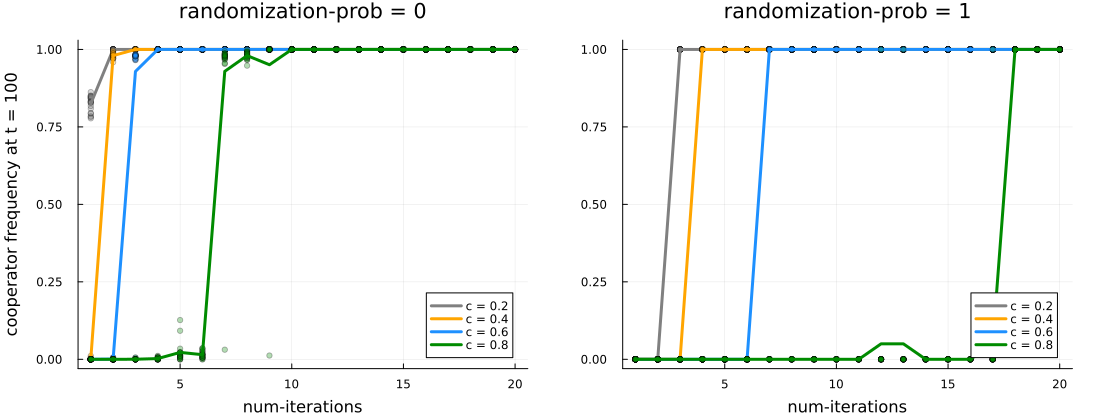

In [ ]:
# Plot Fig 6.8
palette_cs = Dict(0.2 => :gray, 0.4 => :orange, 0.6 => :dodgerblue, 0.8 => :green4)

plt_left = plot(title="randomization-prob = 0", xlabel="num-iterations", ylabel="cooperator frequency at t = 100",
    legend=:bottomright)
for c in c_vals
    sx, sy = results[0.0][c][:scatter]
    scatter!(plt_left, sx, sy; label="", ms=3, alpha=0.30, color=palette_cs[c])
    plot!(plt_left, T_vals, results[0.0][c][:mean];
        lw=3, marker=:none, color=palette_cs[c], label="c = $(c)")
end

plt_right = plot(title="randomization-prob = 1", xlabel="num-iterations", ylabel="",
    legend=:best)
for c in c_vals
    sx, sy = results[1.0][c][:scatter]
    scatter!(plt_right, sx, sy; label="", ms=3, alpha=0.30, color=palette_cs[c])
    plot!(plt_right, T_vals, results[1.0][c][:mean];
        lw=3, marker=:none, color=palette_cs[c], label="c = $(c)")
end

finalfig = plot(plt_left, plt_right; layout=(1, 2), size=(1100, 420), margin=5mm)
display(finalfig)